# SpatialQuery for query of spatial transcriptomics data
This notebook elucidates the application of SpatialQuery for conducting rapid spatial analyses on extensive collections of spatial transcriptomics data. As an advanced spatial analysis tool, SpatialQuery facilitates the expeditious exploration of cell type relationships and patterns within spatial transcriptomics datasets. Through the construction of efficient KD-tree indices for spatial locations annotated with cell types, this tool enables high-speed queries at single-cell resolution within a spatial context.

The analytical capabilities of SpatialQuery span both single and multiple dataset scenarios:

### Single Dataset Analysis:

1. Visualization of spatial distribution of cell types
2. Exploration of frequent patterns of cell types across the entire field of view
3. For a given cell type of interest, analysis of neighboring cell type compositions surrounding a specific cell type of interest including:   
    a) Identification of frequent patterns    
    b) Enrichment analysis of patterns
7. Customized visualization tools for result interpretation


### Multiple Dataset Analysis:

1. Collective exploration of frequent cell type patterns around a cell type of interest
2. Enrichment analysis of specified patterns across datasets
3. For datasets sampled across various conditions or states:
    Differential analysis to identify statistically significant and condition-specific cell type patterns



By leveraging optimized spatial indexing techniques, this tool ensures efficient processing of complex spatial queries, yielding biologically meaningful results even for large-scale datasets. The implementation of KD-trees allows researchers to uncover spatial organization and cell-cell interactions in tissue samples with unprecedented speed and precision.

In [2]:
from SpatialQuery import spatial_query
from SpatialQuery import spatial_query_multi

import anndata as ad
import pandas as pd
import warnings
import os
import numpy as np


warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 500)


# Load spatial transcriptomics data
As an example, we use Slide-seq datasets, downloaded from HuBMAP (https://portal.hubmapconsortium.org/search?raw_dataset_type_keyword-assay_display_name_keyword[Slide-seq][0]=Slideseq&raw_dataset_type_keyword-assay_display_name_keyword[Slide-seq][1]=Slideseq%20%5BSalmon%5D&entity_type[0]=Dataset), which include cell type annotations, to demonstrate the application of SpatialQuery.


In [3]:
# adatas = [ad.read_h5ad(uuid + '/secondary_analysis.h5ad') for uuid in uuids]
file_path = "YourFilePath/CZI_kidney"
files = os.listdir(file_path)
files = [f for f in files if f.endswith('.h5ad')]

print(f"Number of datasets: {len(files)}")

from tqdm import tqdm

adatas = []
for f in tqdm(files):
    adatas.append(ad.read_h5ad(os.path.join(file_path, f)))


Number of datasets: 84


100%|██████████| 84/84 [01:31<00:00,  1.09s/it]


In [4]:
len(adatas)

84

In [5]:
num_cells = np.sum([adata.n_obs for adata in adatas])
print(f"Number of total cells: {num_cells}")

Number of total cells: 2000601


# SpatialQuery for Single Field of View (FOV) Analysis
This section demonstrates the application of SpatialQuery for analyzing a single field of view (FOV) in spatial transcriptomics data. The process begins with the initialization of a SpatialQuery object, which involves constructing a KD-tree using spatial location data and storing labels for each spot.

In this example, we utilize an annotated AnnData object loaded from "secondary_analysis.h5ad". The key components for initialization are:

1. Cell annotations: Stored in AnnData.obs, accessed using the label_key parameter.
2. Spatial locations: Stored in AnnData.obsm, accessed using the spatial_key parameter.
3. Dataset identifier: An optional dataset parameter can be provided to uniquely name each FOV.

In [8]:
spatial_key = 'X_spatial'
label_key = 'predicted_label'

adata = adatas[0]

single_sp = spatial_query(
    adata=adata,
    dataset="single-fov",
    spatial_key=spatial_key,
    label_key=label_key,
    leaf_size=10
)


### Visualizaiton of the Spatial Distribution of Cell Types by plot_fov

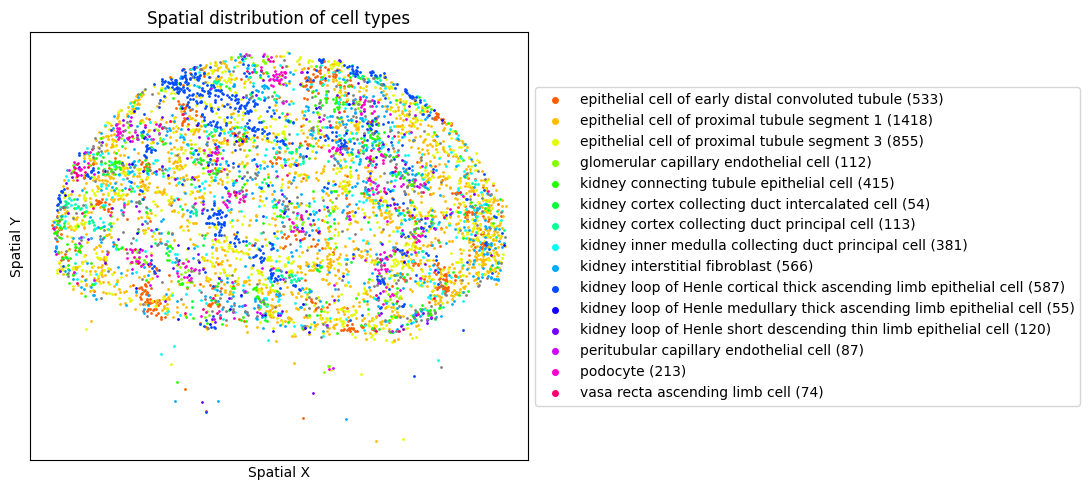

In [9]:
single_sp.plot_fov(
    min_cells_label=50,  # displaying cell types more than 50 cells
    title='Spatial distribution of cell types', 
    fig_size=(10, 5)
)

### Identification of Frequent Patterns of Cell Types in Single FOV with find_patterns/rand
In the absence of prior knowledge about the dataset, the find_patterns_grid and find_patterns_rand methods can be employed to identify frequent patterns of cell types in cellular neighborhoods across whole FOV. These functions serve as valuable tools for preliminary data exploration, offering insights into the spatial organization of different cell types within the tissue.

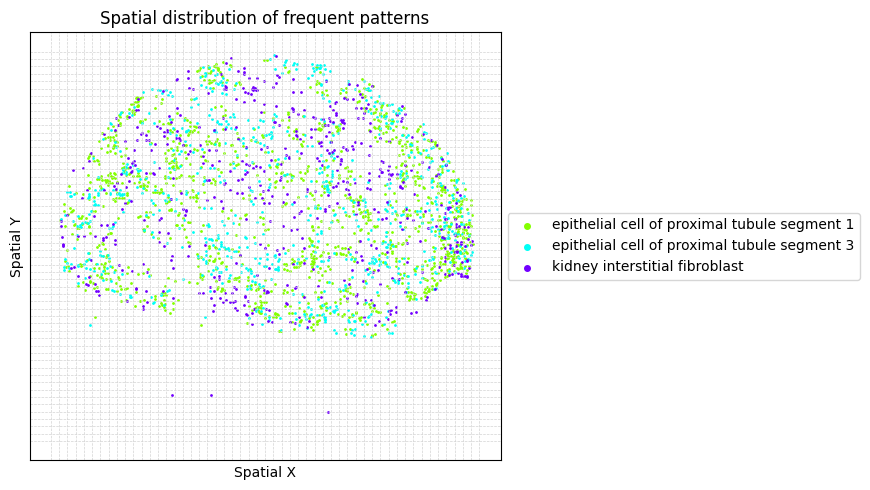

In [11]:
fp_grid = single_sp.find_patterns_grid(
    max_dist=100,      # the radius of neighborhood to be considered
    min_size=0,        # minimum number of cells allowed in a neighborhood
    min_support=0.5,   # lower bound of the support value for the frequency of each pattern
    if_display=True,   # whether to display spatial distribution of frequent patterns of cell types
    fig_size=(8, 5),   # customize size of the output figure
    return_cellID=False, # whether to return the IDs of neighboring cells in frequent patterns
)

In [12]:
fp_grid[['support', 'itemsets']]

,support,itemsets
0,0.563431,[kidney interstitial fibroblast]
1,0.534842,"[epithelial cell of proximal tubule segment 1, epithelial cell of proximal tubule segment 3]"


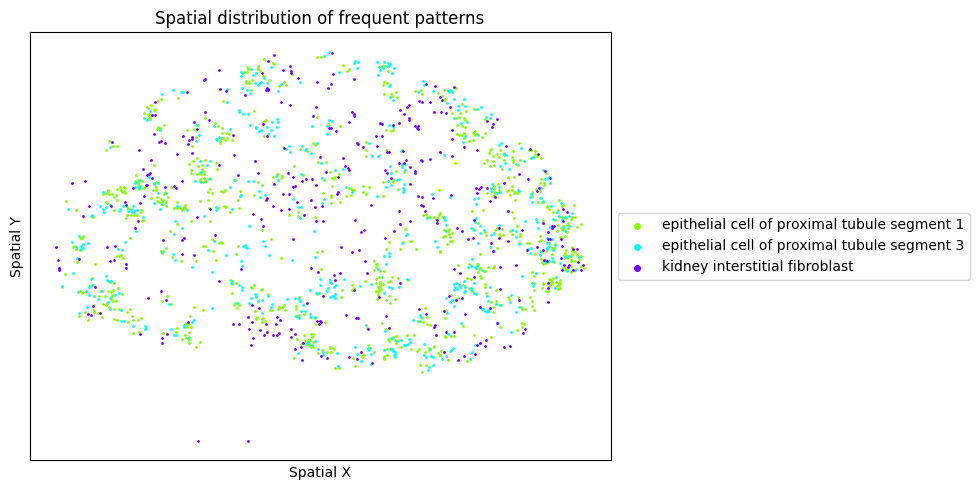

In [13]:
fp_rand = single_sp.find_patterns_rand(
    max_dist=100.0,
    n_points=1000,     # number of randomply selected points
    min_support=0.5,
    min_size=0,
    if_display=True,
    fig_size=(9, 5),
    seed=2024
)


In [14]:
fp_rand

,support,itemsets
0,0.555896,[kidney interstitial fibroblast]
1,0.543645,"[epithelial cell of proximal tubule segment 1, epithelial cell of proximal tubule segment 3]"


In addition to visualizing the spatial distribution of all cells in frequent patterns, SpatialQuery also supports the visualization of spatial distributions for individual patterns. This feature allows for a more detailed examination of specific pattern distribution within the tissue.

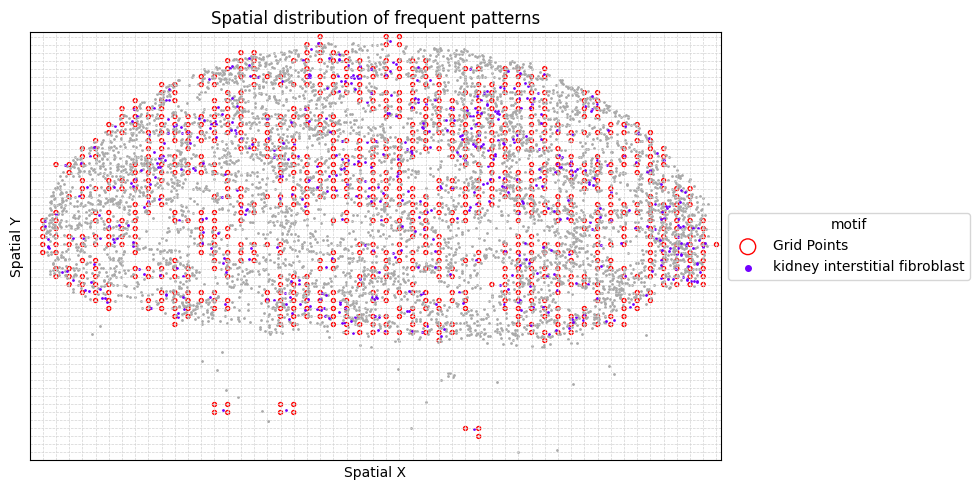

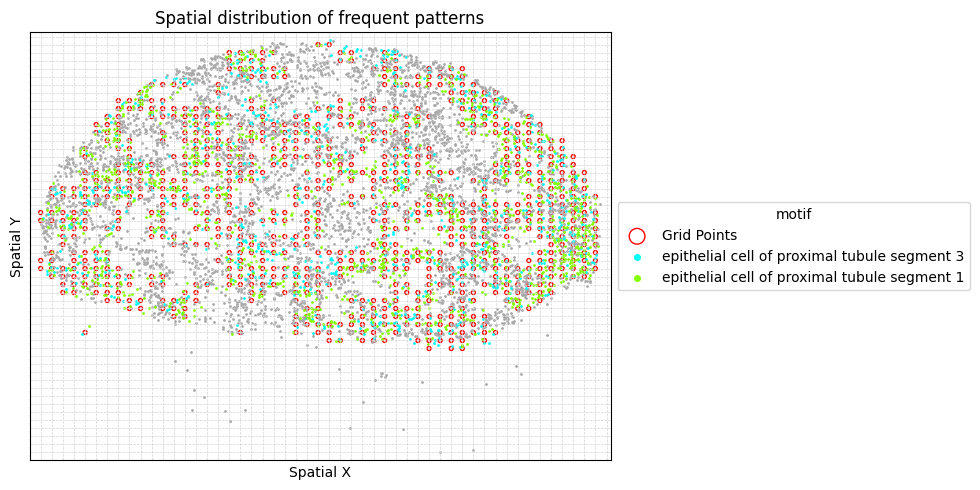

In [15]:
fp_grid = single_sp.find_patterns_grid(
    max_dist=100,      
    min_size=0,        
    min_support=0.5,   
    if_display=False,   
    fig_size=(8, 5),   
    return_cellID=True, # return the IDs of neighboring cells in frequent patterns
)

for motif in fp_grid['itemsets']:
    single_sp.plot_motif_grid(
        motif=motif,
        fp=fp_grid,
        fig_size=(9,5),
        max_dist=100.0
    )


### Identification of Frequent Patterns Around a Cell Type of Interest with find_fp_knn/dist

For researchers interested in exploring the microenvironment surrounding a specific cell type, SpatialQuery offers targeted analysis capabilities. Users can specify a central cell type of interest and subsequently identify frequent patterns in its neighborhood using either k-nearest neighbors (kNN) or radius-based approaches. This functionality allows for the detailed examination of cellular contexts and potential interactions specific to the chosen cell type.

The analysis can be performed as follows:

1. Specify the cell type of interest
2. Choose between kNN or radius-based neighborhood definition
3. Set appropriate parameters (k value for kNN or radius for radius-based approach)
4. Execute the pattern identification algorithm
5. Analyze the resulting frequent patterns in the context of the specified cell type

In the following usecase, podocyte is studied as the central cell type.

In [16]:
central_ct = 'podocyte'
fp_knn = single_sp.find_fp_knn(
    ct=central_ct,
    k=30,
    min_support=0.7
)
fp_knn

,support,itemsets
0,0.830986,"[glomerular capillary endothelial cell, kidney interstitial fibroblast, podocyte]"
1,0.741784,"[epithelial cell of proximal tubule segment 1, podocyte]"
2,0.737089,"[epithelial cell of proximal tubule segment 1, kidney interstitial fibroblast]"
3,0.713615,"[epithelial cell of proximal tubule segment 1, glomerular capillary endothelial cell]"
4,0.704225,[epithelial cell of proximal tubule segment 3]


In [17]:
# Same functionality but using radius-based neighborhood

central_ct = 'podocyte'
fp_dist = single_sp.find_fp_dist(
    ct=central_ct,
    max_dist=100,
    min_support=0.5,
    min_size=0,
)
fp_dist

,support,itemsets
0,0.544601,"[glomerular capillary endothelial cell, kidney interstitial fibroblast, podocyte]"


### Enrichment Analysis of Patterns Around Central Cell Type with motif_enrichment_knn/dist
After identifying patterns of interest, either through frequent pattern analysis or based on prior knowledge, SpatialQuery enables users to perform enrichment analysis. This analysis determines whether a specific pattern is significantly enriched in the neighborhood of a central cell type using a hypergeometric test. The functions motif_enrichment_knn and motif_enrichment_dist facilitate this analysis for k-nearest neighbors (kNN) and distance-based neighborhoods, respectively.

Key aspects of this functionality include:

1. Pattern selection: Users can input patterns derived from frequent pattern analysis or specify custom patterns of interest.
2. Central cell type specification: The cell type around which the enrichment analysis will be performed.
3. Neighborhood definition: Choose between kNN or distance-based approaches.
4. Statistical testing: Utilization of the hypergeometric test to assess significance.
5. Result interpretation: Evaluation of enrichment levels and statistical significance.

This analysis helps researchers identify statistically significant spatial associations between cell types, potentially revealing important cellular interactions or tissue organization principles.

In [18]:
motif = fp_knn['itemsets'][0]
motif_sig_knn = single_sp.motif_enrichment_knn(
    ct=central_ct,
    motifs=motif, 
)

motif_sig_knn

,center,motifs,n_center_motif,n_center,n_motif,p-values,corrected p-values,if_significant
0,podocyte,"[glomerular capillary endothelial cell, kidney interstitial fibroblast, podocyte]",176,213,960,4.568461e-109,4.568461e-109,True


In [20]:
# Same analysis but with radius-based neighborhood
motif = fp_dist['itemsets'][0]
motif_sig_dist = single_sp.motif_enrichment_dist(
    ct=central_ct,
    motifs=motif, 
)

motif_sig_dist

,center,motifs,n_center_motif,n_center,n_motif,p-values,corrected p-values,if_significant
0,podocyte,"[glomerular capillary endothelial cell, kidney interstitial fibroblast, podocyte]",116,213,427,8.147769e-82,8.147769e-82,True


### Visualizaiton of Specified Cell Types around Central Cell Type with plot_motif_celltype
Moreover, SpatialQuery supports the visualization of specified patterns around a central cell type using the plot_motif_celltype function. This feature enables researchers to visually inspect the spatial distribution of particular cellular arrangements within the tissue context. The red circle denotes the central cell type while the colorful dots correspond to neighboring cell types in given pattern.

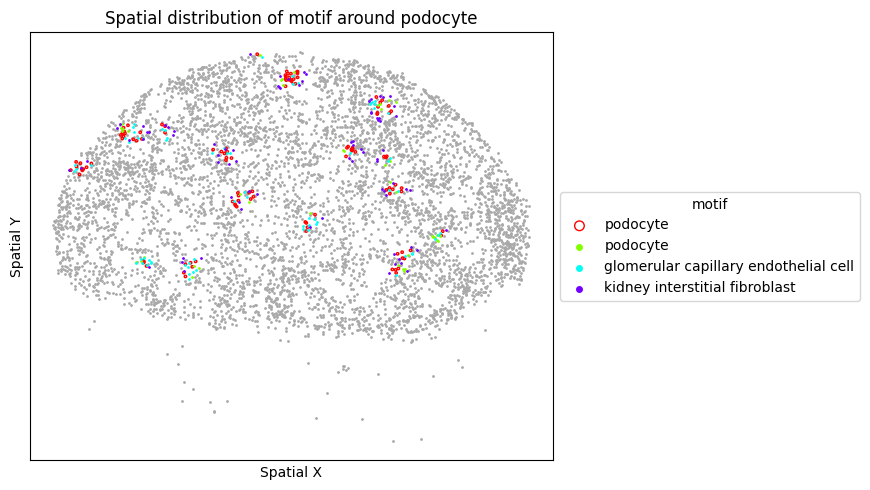

In [19]:
motif = fp_knn['itemsets'][0]
single_sp.plot_motif_celltype(
    ct=central_ct, 
    motif=motif, 
    fig_size=(8, 5)
)

### Integrative Analysis of Multiple FOVs
Morever, SpatialQuery extends its analytical capabilities to multiple FOVs, enabling integrative analysis across different samples or experimental conditions. Key features include:
1. Identification of frequent patterns across multiple FOVs
2. Enrichment analysis of cellular patterns across samples
3. Differential pattern analysis for datasets from multiple conditions

To distinguish between FOVs, users should specify unique, indicative dataset names for each FOV during initialization.
This functionality allows researchers to validate findings across multiple samples, identify conserved spatial patterns, and reveal condition-specific changes in tissue architecture.

For illustrative purposes, we create simulated dataset names representing "normal" and "disease" states to showcase the workflow for comparing patterns between different biological conditions.

In [25]:

datasets_name = ['normal'] * 5 + ['disease'] * (len(adatas) - 5)
multi_sp = spatial_query_multi(
    adatas=adatas,  
    datasets=datasets_name,
    spatial_key=spatial_key, 
    label_key=label_key,
    leaf_size=10
)


### Identification of Frequent Patterns of Cell Types accross Multiple FOVs with find_fp_knn/dist
SpatialQuery provides functions find_fp_knn and find_fp_dist for identifying frequent patterns of cell types across multiple FOVs. These functions are analogous to their single-FOV counterparts. Users can explicitly define which datasets (FOVs) to include in the analysis. If not specified, the functions will, by default, use all available datasets.

In [26]:
central_ct = "podocyte"
fp_knn_multi = multi_sp.find_fp_knn(
    ct=central_ct, 
    dataset='normal',
    k=30,
    min_support=0.5,
    max_dist=100
)

fp_knn_multi

,support,itemsets
0,0.654391,"[glomerular capillary endothelial cell, podocyte]"
1,0.563739,[kidney loop of Henle cortical thick ascending limb epithelial cell]
2,0.526912,"[kidney interstitial fibroblast, podocyte]"


In [28]:
# Radius-based neighborhoods
central_ct = "podocyte"
fp_dist_multi = multi_sp.find_fp_dist(
    ct=central_ct, 
    dataset='normal',
    max_dist=100,
    min_support=0.5,
)

fp_dist_multi

,support,itemsets
0,0.654391,"[glomerular capillary endothelial cell, podocyte]"
1,0.575071,[kidney loop of Henle cortical thick ascending limb epithelial cell]
2,0.526912,"[kidney interstitial fibroblast, podocyte]"
3,0.507082,"[glomerular capillary endothelial cell, kidney interstitial fibroblast]"


### Enrichment Analysis of Patterns Around Central Cell Type across Multiple FOVs with motif_enrichment_knn/dist
SpatialQuery also extends its enrichment analysis capabilities to multiple FOVs, employing the same methodological approach as used in single FOV analysis.

In [29]:
# KNN neighborhoods
motif = fp_knn_multi['itemsets'][0]
motif_sig_knn_multi = multi_sp.motif_enrichment_knn(
    ct=central_ct,
    motifs=motif, 
    dataset='normal'
)

motif_sig_knn_multi

,center,motifs,n_center_motif,n_center,n_motif,p-values,corrected p-values,if_significant
0,podocyte,"[glomerular capillary endothelial cell, podocyte]",265,353,1681,0.0,0.0,True


In [30]:
# Radius-based neighborhoods
motif = fp_dist_multi['itemsets'][0]
motif_sig_dist_multi = multi_sp.motif_enrichment_dist(
    ct=central_ct,
    motifs=motif, 
    dataset='normal'
)

motif_sig_dist_multi

,center,motifs,n_center_motif,n_center,n_motif,p-values,corrected p-values,if_significant
0,podocyte,"[glomerular capillary endothelial cell, podocyte]",231,353,1379,4.714671e-298,4.714671e-298,True


## Differential Pattern Analysis across Conditions or Tissues

When working with multiple FOVs representing different conditions or tissue types, SpatialQuery enables differential analysis of frequent patterns surrounding a specific cell type. This powerful feature allows researchers to:

1. Compare cellular neighborhood compositions between two distinct groups of datasets
2. Identify patterns that are significantly enriched or depleted in one condition relative to another
3. Reveal condition-specific or tissue-specific changes in the microenvironment of a central cell type

By leveraging this differential analysis, researchers can uncover alterations in tissue architecture or cellular interactions that may be associated with different biological states, disease progression, or tissue-specific organizations.

In [40]:

out_knn = multi_sp.differential_analysis_knn(
    ct=central_ct,
    datasets=['normal', 'disease'],
    k=20,
    min_support=0.3,
    max_dist=100,
)

In [47]:
out_knn['normal']

,itemsets,corrected_p_values
0,"(kidney loop of Henle cortical thick ascending limb epithelial cell,)",0.000353


The differential analysis reveals that a specific cell type exhibits significant enrichment in the neighborhood of podocytes under "normal" conditions compared to "disease" conditions.

In [42]:
out_knn['disease']

,itemsets,corrected_p_values


No significant patterns in "disease" conditions nearby podocyte.

In [50]:
# Same differential analysis with radius-based neighborhood
out_dist = multi_sp_.differential_analysis_dist(
    ct=central_ct,
    datasets=['normal', 'disease'],
    max_dist=100.0,
    min_support=0.3,
)


In [51]:
out_dist['normal']

,itemsets,corrected_p_values
0,"(kidney loop of Henle cortical thick ascending limb epithelial cell,)",0.000706
1,"(kidney loop of Henle short descending thin limb epithelial cell,)",0.000706


In [52]:
out_dist['disease']

,itemsets,corrected_p_values
0,"(kidney connecting tubule epithelial cell,)",0.002245
1,"(kidney interstitial fibroblast,)",0.002245
